In [148]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import os
import nibabel as nib
import SimpleITK as sitk
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from skimage.transform import resize

In [2]:
a = np.array([[0,2.0,9.0],[3.0,4.0,10.0],[1.0,2.0,9.0]])
b = np.array([[5,6,1],[66,7,5],[1,2,9]])
d = np.array([[5,6,1],[66,7,5],[1,2,9]])

In [3]:
h = np.stack((a,b,d,d))

print(h)

[[[ 0.  2.  9.]
  [ 3.  4. 10.]
  [ 1.  2.  9.]]

 [[ 5.  6.  1.]
  [66.  7.  5.]
  [ 1.  2.  9.]]

 [[ 5.  6.  1.]
  [66.  7.  5.]
  [ 1.  2.  9.]]

 [[ 5.  6.  1.]
  [66.  7.  5.]
  [ 1.  2.  9.]]]


In [4]:
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")
bb_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")

In [275]:
def load_image(path):
    img = pydicom.read_file(path)
    img = img.pixel_array
    return resize(img, (100, 100))

In [246]:
# def window(img):
#     img = np.resize(img,(224,224))
#     img[np.where(img<0)] = 0
#     img = img-img.min()
#     maxx = img.max()
# #     a = (img.copy())*1.0
#     b = (img.copy())*1.0
# #     c = (img.copy())*1.0
# #     a[np.where(a>maxx/3)] = maxx/3 
# #     a = a/(maxx/3)
# #     c[np.where(c<(2*maxx)/3)] = (2*maxx)/3
# #     c =  (c-(2*maxx)/3)/(maxx/3)
#     #b[np.where(b>(3*maxx/4))] = 3*(maxx/4)
#     b[np.where(b<(maxx/2))] = maxx/2
#     b = (b-(maxx/2)) / (maxx/2)
#     return np.stack((b,b,b),axis=-1)

In [276]:
def window(img):
    img[np.where(img<0)] = 0
    mean = img.mean()
    std = img.std()
    img[np.where(img>(mean+(3*std)))] = (mean+(3*std))
    img = img-img.min()
    maxx = img.max()
    img[np.where(img<(maxx/2))] = maxx/2
    img = (img-(maxx/2)) / (maxx/2)
    return img

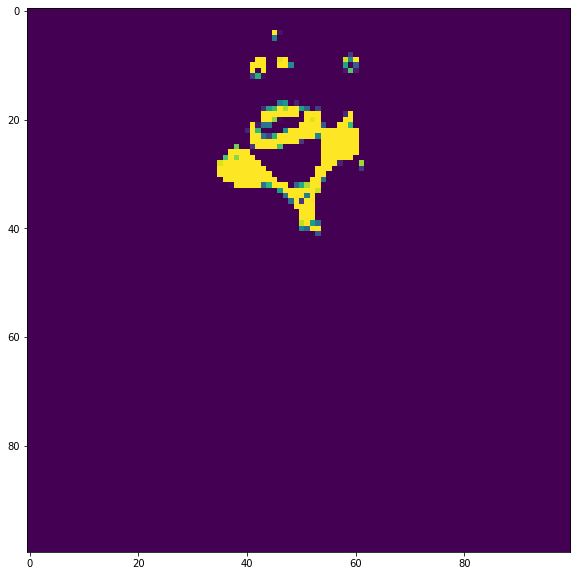

In [277]:
plt.figure(figsize = (10,10))
plt.imshow(window(load_image("../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10856/252.dcm")))


In [278]:
path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10697/"
final_ct = window(load_image(path+"30.dcm")).reshape(100,100,1)
len10percent = len(os.listdir(path))//10
for image in range(len10percent, len(os.listdir(path))-len10percent):
    img = window(load_image(path+str(image)+".dcm")).reshape(100,100,1)
    final_ct = np.append(final_ct, img, axis=-1)

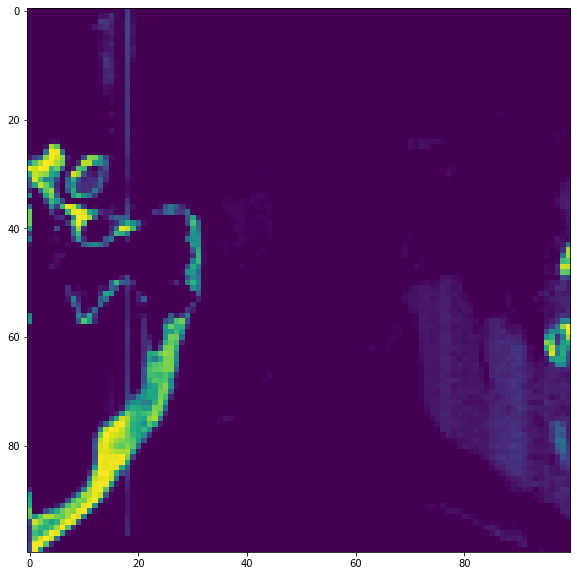

In [288]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.resize(final_ct[:,5],(100,100)))

0.0

In [251]:
max_list =[]
mean_list = []
path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10697"
for image in range(1, len(os.listdir(path))+1):
    img = load_image(path+'/'+str(image)+'.dcm')
    maxx = img[np.where(img>500)].max()
    meann = img[np.where((img>1100) & (img<1200))].mean()
    max_list.append(maxx)
    mean_list.append(meann)

IndentationError: expected an indented block (687258735.py, line 5)

In [252]:
plt.plot(mean_list)

NameError: name 'mean_list' is not defined

In [ ]:
seg = sitk.ReadImage('../input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.780.nii')
seg = sitk.GetArrayFromImage(seg)
seg.shape

In [ ]:

image_bytes = tf.io.read_file('../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.780/65.dcm')
image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

In [ ]:
load_image('../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.780/1.dcm')

In [ ]:
plt.imshow(window(np.array(image[0])),cmap = 'gray')

In [ ]:
seg_path = '../input/rsna-2022-cervical-spine-fracture-detection/segmentations'
index_list = []
data_list = []
for ct in tqdm(os.listdir(seg_path)):
    seg = sitk.ReadImage(seg_path + '/' + ct)
    seg = sitk.GetArrayFromImage(seg)
    for pic in range(1,seg.shape[0]):
        if seg[-pic,::-1,:].max()>0:
            index_list.append(ct[:-4]+'/'+str(pic)+'.dcm')
            data_list.append(1)
        else:
            index_list.append(ct[:-4]+'/'+str(pic)+'.dcm')
            data_list.append(0)

In [ ]:
c_data = pd.Series(data = data_list,index = index_list)

In [ ]:
!mkdir c_data

In [ ]:
c_data.to_csv('./c_data/c_data.csv')

# AI for finding slices with spine

In [ ]:
data = pd.read_csv('../input/slices-with-spine/c_data.csv')

In [ ]:
data.columns = ['adress' , 'label']
data

In [ ]:
def data_gen(df = data):
    for i in range(25745):
        try:
            path = '../input/rsna-2022-cervical-spine-fracture-detection/train_images/'+df.iloc[i]['adress']
            #image =  np.array(tfio.image.decode_dicom_image(tf.io.read_file(path) ,  dtype=tf.float16))
            image = window(load_image(path))
            label = df.iloc[i]['label']
            yield image , label
        except:
            continue
def test_gen(df = data):
    for i in range(25745,26500):
        try:
            path = '../input/rsna-2022-cervical-spine-fracture-detection/train_images/'+df.iloc[i]['adress']
            image = window(load_image(path))
            label = df.iloc[i]['label']
            yield image , label  
        except:
            continue

In [ ]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     (tf.float32, tf.float32),
    (tf.TensorShape([224,224,3]), tf.TensorShape([])))
testset = tf.data.Dataset.from_generator(
     data_gen,
     (tf.float32, tf.float32),
    (tf.TensorShape([224,224,3]), tf.TensorShape([])))

In [ ]:
dataset = dataset.batch(10)

dataset=dataset.prefetch(1)

testset = testset.batch(10)

testset=testset.prefetch(1)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=2,
)
input_b = tf.keras.layers.Input(shape = (224,224,3))
x = resnet(input_b)
x = tf.keras.layers.Flatten()(x)
x =tf.keras.layers.BatchNormalization()(x)
x =tf.keras.layers.Dense(32,activation = 'relu')(x)
x =tf.keras.layers.Dense(16,activation = 'relu')(x)
x =tf.keras.layers.Dense(8,activation = 'relu')(x)
x =tf.keras.layers.Dense(4,activation = 'relu')(x)
x =tf.keras.layers.Dense(1,activation = 'sigmoid')(x)
model = tf.keras.models.Model(inputs=input_b, outputs=x)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2 ,decay = 0.9),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model_checkpoint_callback_LASSO = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
H = model.fit(dataset,validation_data = testset.take(150),epochs=6,callbacks=[model_checkpoint_callback_LASSO])


In [ ]:
def viz_loss(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    iters = [i for i in range(2)]
    
    plt.plot(iters, train_loss, label="Training Loss")
    plt.plot(iters, val_loss, label="Validation Loss")
    plt.title("A plot of Loss against number of iterations")
    plt.legend()
    plt.show()
    
def viz_acc(history):
    train_loss = history["accuracy"]
    val_loss = history["val_accuracy"]
    iters = [i for i in range(2)]
    
    plt.plot(iters, train_loss, label="Training Accuracy")
    plt.plot(iters, val_loss, label="Validation Accuracy")
    plt.title("A plot of Accuracy against number of iterations")
    plt.legend()
    plt.show()

In [ ]:
viz_loss(H.history)
viz_acc(H.history)